# Customer Retention and Engagement Analysis

This notebook is the appendix for the ppt. It includes the analysis and visualizations used in the presentation
as well as the background work down for it

Note: When converted to a PDF, there might be alignment and page distribution issues

In [1]:
#import statements
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import strftime
from datetime import datetime

In [2]:
#read files
users=pd.read_csv("cleo_users.csv")
user_activity=pd.read_csv("cleo_user_activity.csv")

C:\Users\saads\Anaconda3\envs\PDS\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## User Activity

### Daily active users (DAU)

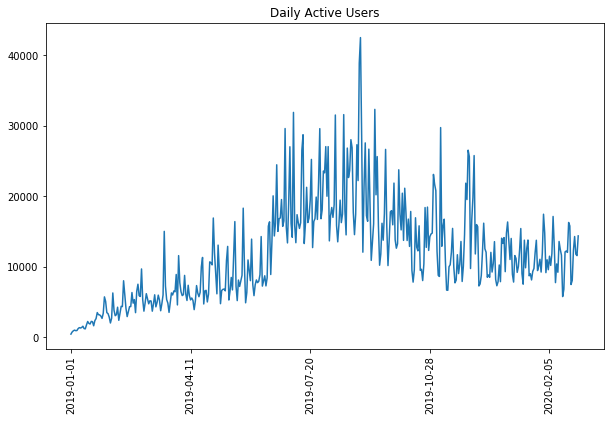

In [3]:

dcounts=user_activity['active_date'].value_counts().sort_index()
dcounts.plot(kind='line', title='Daily Active Users',rot=90, figsize=(10,6))



### Monthly active users (MAU)

In [4]:
user_activity['Month']=user_activity['active_date'].str.slice(0,7)

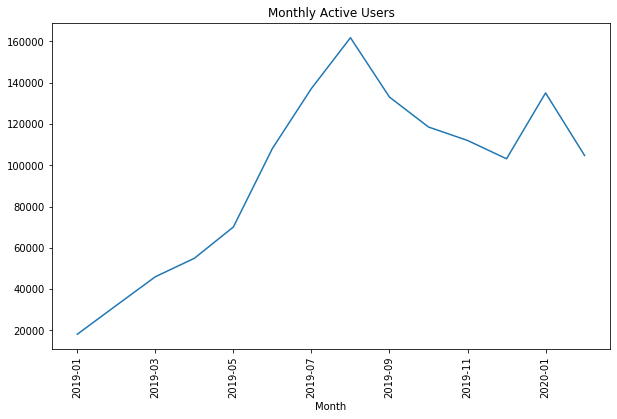

In [5]:

mcounts=user_activity.groupby('Month')['user_id'].nunique()
mcounts.plot(kind='line', title='Monthly Active Users',rot=90, figsize=(10,6))


## Customer Attributes/ Segments

In [28]:
def plot_bar(df,column):
    counts=df[column].value_counts()
    plt.figure()
    sns.barplot(y=counts.index, x=counts.values, alpha=0.8, palette='rocket')
    plt.title('Customer SignUps Segregated by '+ column, fontsize=20)
    plt.xlabel('Number of Occurrences', fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.show()

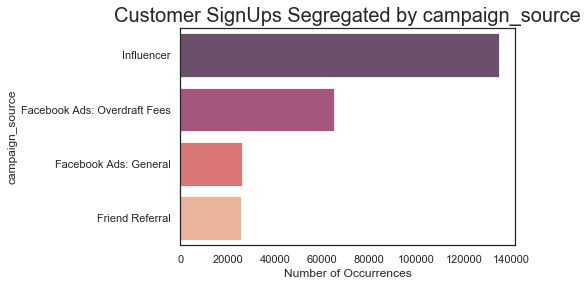

In [29]:
plot_bar(users,'campaign_source')

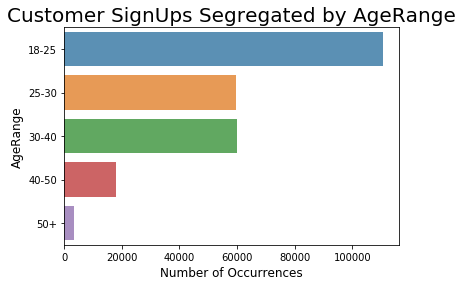

In [8]:
bins = [18, 25, 30, 40, 50, np.inf]
bin_labels = ['18-25', '25-30', '30-40', '40-50', '50+']
users['AgeRange'] = pd.cut(users['age'], bins, labels=bin_labels)
plot_bar(users,'AgeRange')

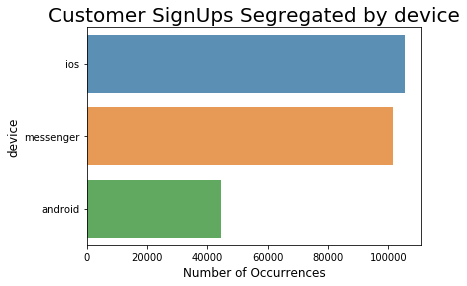

In [9]:
plot_bar(users, 'device')

In [10]:
users['user_country'].value_counts()

US    227477
GB     24343
Name: user_country, dtype: int64

In [11]:
"""This function explores the value over time by month for a given value of an attribute"""
def explore_changes(df, attribute, value):
    df['Month']=users['created_at'].str.slice(0,7)
    user_signup=df[df[attribute] == value]
    mcounts=user_signup.groupby('Month')['id'].nunique()
    mcounts.plot(kind='line', rot=90, figsize=(10,6),label=value,legend=True)
    

### Change in the number of signups through different campaign sources (monthly)

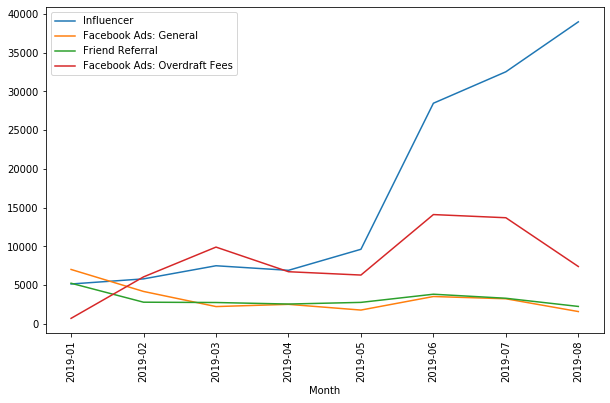

In [12]:

for v in users['campaign_source'].unique():
    explore_changes(users,'campaign_source',v)

### Change in number of signups by agegroups (monthly)

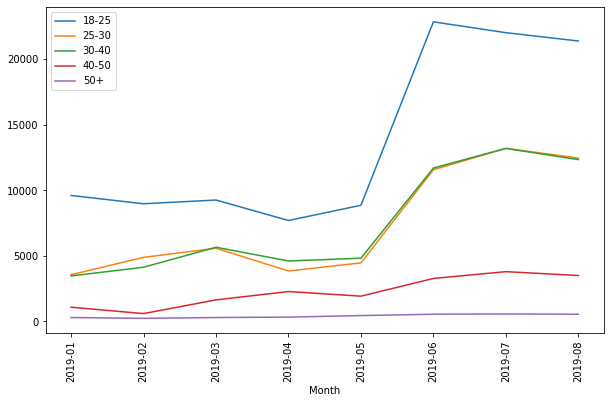

In [13]:

for v in bin_labels:
    explore_changes(users,'AgeRange', v)

In [21]:
users['subscription_created_at'].value_counts()

2019-08-31    420
2019-06-21    372
2019-08-30    326
2019-08-02    324
2019-08-23    309
             ... 
2019-01-07      3
2019-01-19      2
2019-02-03      2
2019-01-01      2
2019-02-07      1
Name: subscription_created_at, Length: 425, dtype: int64

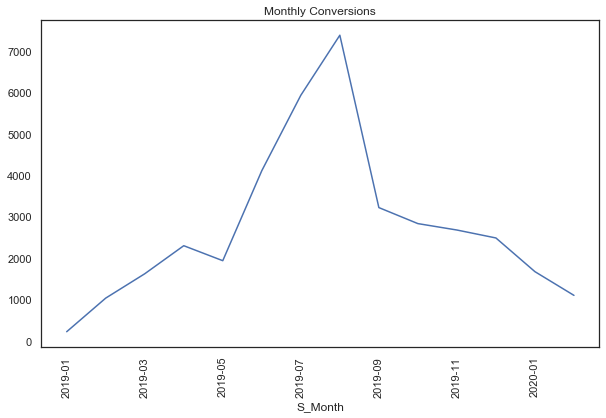

In [23]:
## Conversion Counts
users['S_Month']=users['subscription_created_at'].str.slice(0,7)
ccounts=users.groupby('S_Month')['id'].nunique()
ccounts.plot(kind='line', title='Monthly Conversions',rot=90, figsize=(10,6))

## Customer Retention

In [14]:
##Adding a signup date column to user activity to help with retention analysis
sign_up=dict(zip(users.id, users.created_at))
user_activity['SignUp'] = user_activity['user_id'].map(sign_up)

In [15]:
##Group the users by Cohort
user_activity['CohortGroup'] = user_activity['SignUp'].str.slice(0,7)
grouped = user_activity.groupby(['CohortGroup', 'Month'])
cohorts = grouped.agg({'user_id': pd.Series.nunique})
cohorts.rename(columns={'Month': 'Month',
                        'user_id': 'Total_Users'}, inplace=True)

The cohort analysis code has been adapted from the following source:
http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/

In [16]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's signup.
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

Total_Users  CohortPeriod
CohortGroup Month                             
2019-01     2019-01        18167             1
            2019-02        13229             2
            2019-03        10477             3
            2019-04         9964             4
            2019-05        10180             5

In [17]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['Total_Users'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2019-01    18167
2019-02    18893
2019-03    22439
2019-04    18761
2019-05    20523
Name: Total_Users, dtype: int64

### Plot % of selected cohort groups active against months after signup

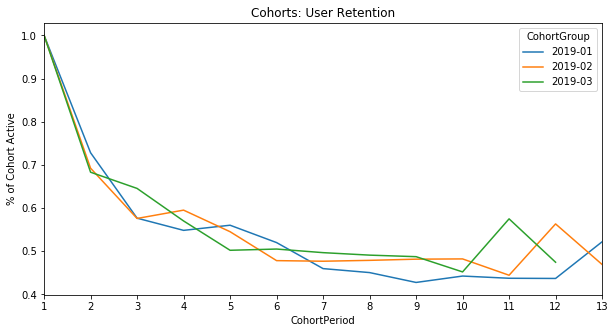

In [18]:

user_retention = cohorts['Total_Users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention[['2019-01', '2019-02', '2019-03']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 13.1, 1))
plt.xlim(1, 13)
plt.ylabel('% of Cohort Active');

### Plot HeatMap to show percentage of cohort groups active after different periods(months) 

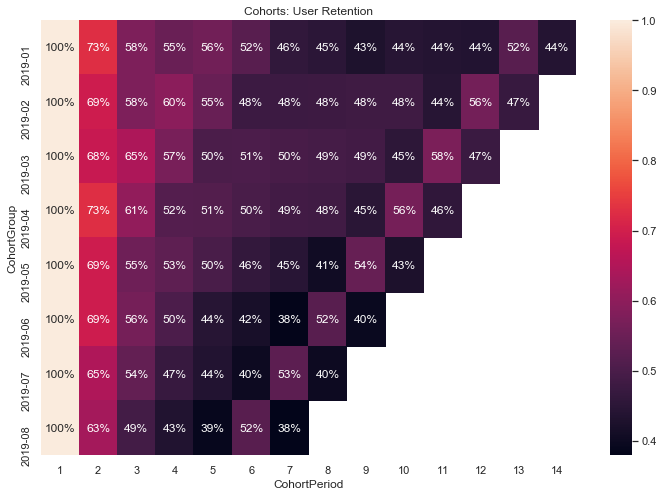

In [19]:

sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');